In [1]:
from model.lit_custom_resnet import LitCustomResnet
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from visualise import plot_csv_logger
import torch

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%load_ext watermark
%watermark -v -p torch,pytorch_lightning

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

torch            : 2.0.1
pytorch_lightning: 2.0.6



In [5]:
import warnings
warnings.filterwarnings('ignore')

# Testing Dataloaders

In [16]:
model = LitCustomResnet()
model.layer3[0]

Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [17]:
num_epochs = 1
model.setup()   # Setup train/test/val dataset
for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(model.train_dataloader()):
        if batch_idx >=3:
            break
        print(" Batch Index:", batch_idx, end="")
        print(" | Batch Size:", label.shape[0], end="")
        print(" | Image Shape:", image.shape, end="")
        print(" | Label Shape:", label.shape)

print("Labels from current batch: ", label)

 Batch Index: 0 | Batch Size: 32 | Image Shape: torch.Size([32, 3, 32, 32]) | Label Shape: torch.Size([32])
 Batch Index: 1 | Batch Size: 32 | Image Shape: torch.Size([32, 3, 32, 32]) | Label Shape: torch.Size([32])
 Batch Index: 2 | Batch Size: 32 | Image Shape: torch.Size([32, 3, 32, 32]) | Label Shape: torch.Size([32])
Labels from current batch:  tensor([9, 5, 5, 6, 3, 6, 2, 1, 7, 5, 6, 7, 5, 1, 0, 0, 2, 3, 9, 6, 7, 7, 1, 0,
        8, 0, 2, 2, 8, 7, 9, 3], dtype=torch.int32)


In [18]:
# For CosineAnnealing 1 cycle Scheduler
epochs = 25
num_steps = len(model.train_dataloader())
num_steps

1407

## Visualising Input Sample and Class distribution

In [19]:
class_map = model.cifar_test.class_to_idx
class_map

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

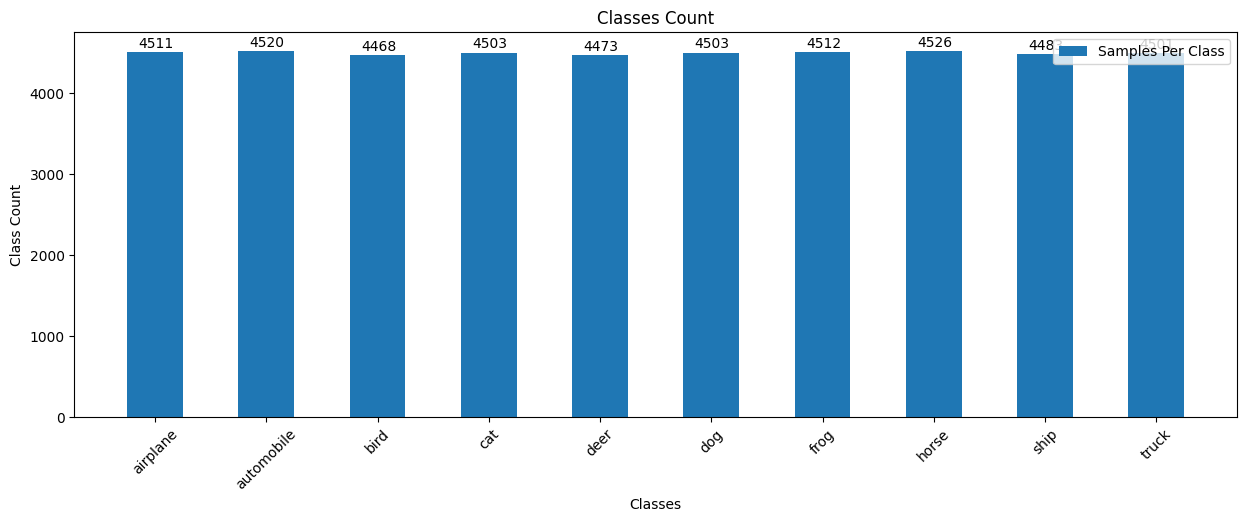

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

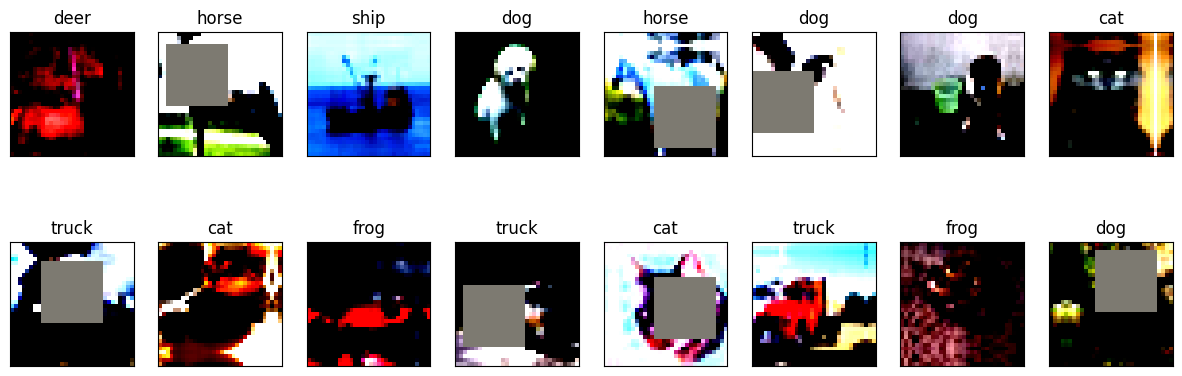

In [39]:
from visualise import print_class_scale, print_samples

torch.manual_seed(1)
show_dataset_analyze = True

if show_dataset_analyze:
    print_class_scale(model.train_dataloader(), class_map)
    print_samples(model.train_dataloader(), class_map, count=16)

# Setup Trainer/Tuner

In [9]:
# For CosineAnnealing 1 cycle Scheduler
model = LitCustomResnet(num_steps=num_steps)
model.setup()

In [10]:
checkpointing = ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)

In [11]:
# Create trainer
trainer = Trainer(
    precision=16,   # Precision means float16, float32, float8 etc.. i6 means float16. Reducing precision increases speed but reduces accuracy slightly
    accelerator="mps",
    devices=1,
    max_epochs=epochs,
    #logger= TensorBoardLogger("logs/"),
    logger = CSVLogger(save_dir="trained_model/", name="best_model"),
    callbacks= [checkpointing],
    default_root_dir=("trained_model/"),
    #profiler="simple",
    #strategy="ddp",
    #fast_dev_run=10
)

#create tuner
tuner = Tuner(trainer)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Finding Batch Size

In [12]:
# 1- Power it starts at batch size = 1, then it raises it from 2^2 > 2^3 > 2^4 .... so on until it goes out of memory
#tuner.scale_batch_size(model, mode="power")

# 2- binary search finds max batch size using binary search
#tuner.scale_batch_size(model, mode="binsearch")

In [13]:
#print(f"Failed on : {model.batch_size}")
model.batch_size = 512

### Finding Learning Rate

In [14]:
# To Set view option from scientific to noraml
torch.set_printoptions(sci_mode=False, precision= 10)
print(4.38e-02) # It means 1 x e^-8

0.0438


In [15]:
# Find Learning Rate
# Then set hparams.lr or hparams.learning_rate to the found learning rate value
lr_finder = tuner.lr_find(
    model=model, train_dataloaders=model.train_dataloader(), val_dataloaders=model.val_dataloader(),
    #min_lr=1e-4,
    max_lr=1, num_training=200, mode="exponential",
    #early_stop_threshold=3.0, 
)

Files already downloaded and verified
Files already downloaded and verified


Finding best initial lr:  99%|█████████▉| 198/200 [01:22<00:00,  2.40it/s]
LR finder stopped early after 198 steps due to diverging loss.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at trained_model/.lr_find_9d152264-a46d-467a-8c7e-39ec80193daa.ckpt
Restored all states from the checkpoint at trained_model/.lr_find_9d152264-a46d-467a-8c7e-39ec80193daa.ckpt


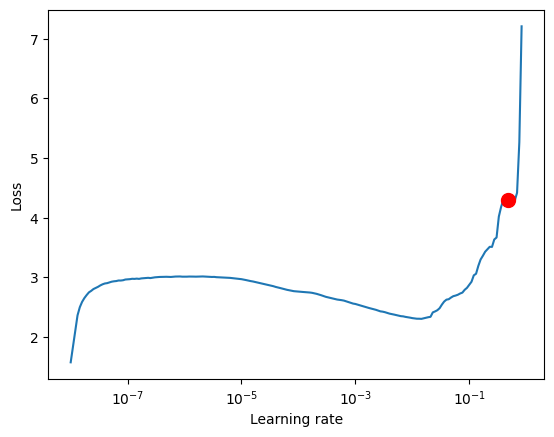

In [16]:
fig = lr_finder.plot(suggest=True)

In [17]:
new_lr = lr_finder.suggestion()
new_lr

0.47863009232263803

In [18]:
model.max_lr = new_lr

# Training Model

In [19]:
trainer.fit(model)

Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type               | Params
--------------------------------------------------
0 | prep_layer | Sequential         | 1.9 K 
1 | layer1     | Sequential         | 74.0 K
2 | r1         | Sequential         | 295 K 
3 | layer2     | Sequential         | 295 K 
4 | layer3     | Sequential         | 1.2 M 
5 | r2         | Sequential         | 4.7 M 
6 | maxpool    | MaxPool2d          | 0     
7 | fc         | Linear             | 5.1 K 
8 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Epoch 24: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s, v_num=0, train_loss=0.408, train_acc=0.864, val_loss=0.358, val_acc=0.878]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s, v_num=0, train_loss=0.408, train_acc=0.864, val_loss=0.358, val_acc=0.878]


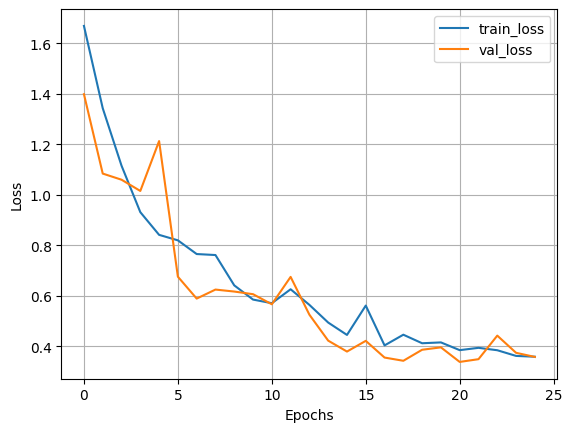

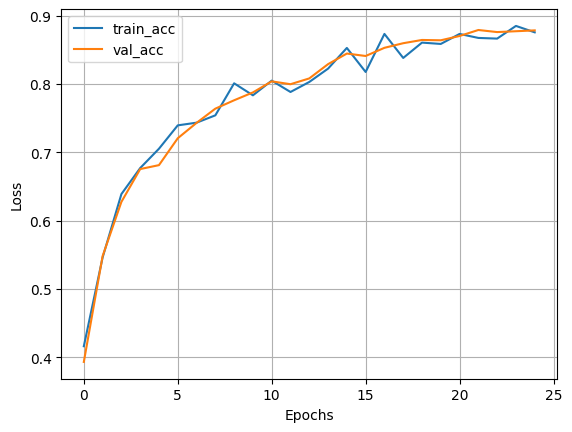

In [20]:
plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

# Test Using Best/Last Checkpoint

In [29]:
best_path = trainer.checkpoint_callback.best_model_path
best_path

'trained_model/best_model/version_0/checkpoints/epoch=21-step=1936.ckpt'

In [23]:
trainer.test(model=model, ckpt_path="best")

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at trained_model/best_model/version_0/checkpoints/epoch=21-step=1936.ckpt
Loaded model weights from the checkpoint at trained_model/best_model/version_0/checkpoints/epoch=21-step=1936.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8813999891281128
        val_loss            0.3679935038089752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3679935038089752, 'val_acc': 0.8813999891281128}]

In [24]:
path = trainer.checkpoint_callback.last_model_path
path

'trained_model/best_model/version_0/checkpoints/last.ckpt'

In [25]:
trainer.test(model=model, ckpt_path="last")

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/qureshsu/Learning/TSAI/Git_Repos/ERAV1_S10/S12/trained_model/best_model/version_0/checkpoints/last.ckpt
Loaded model weights from the checkpoint at /Users/qureshsu/Learning/TSAI/Git_Repos/ERAV1_S10/S12/trained_model/best_model/version_0/checkpoints/last.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8779000043869019
        val_loss            0.37880074977874756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.37880074977874756, 'val_acc': 0.8779000043869019}]

# Loading Saved Model

In [24]:
load_model = model.load_from_checkpoint(
    checkpoint_path="trained_model/best_model/version_0/checkpoints/epoch=21-step=1936.ckpt", map_location=torch.device("cpu")
)
load_model.eval()

LitCustomResnet(
  (prep_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (r1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(

In [31]:
trainer.test(load_model, model.test_dataloader())

Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8813999891281128
        val_loss            0.3679935038089752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3679935038089752, 'val_acc': 0.8813999891281128}]

# Incorrect Predictions

In [25]:
from utils import get_incorrrect_predictions, get_device
use_cuda, use_mps, device = get_device()
load_model.setup()
incorrect = get_incorrrect_predictions(load_model, load_model.val_dataloader(), lightning_mode=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total Incorrect Predictions 336


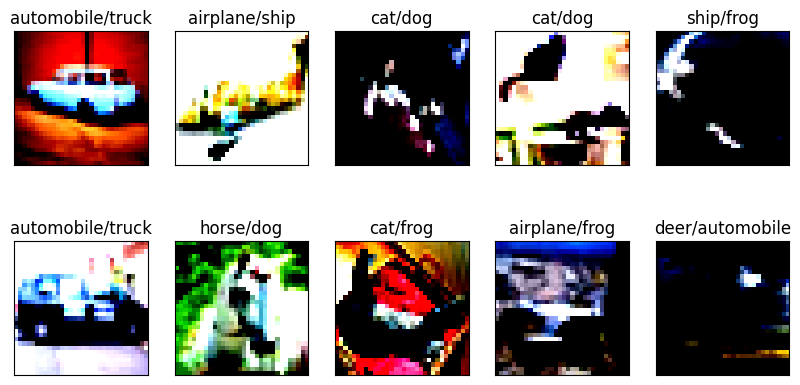

In [27]:
from visualise import plot_incorrect_predictions

labels_mapping = {idx:cls for cls, idx in class_map.items()}
plot_incorrect_predictions(incorrect, labels_mapping, 10)

# GradCAM

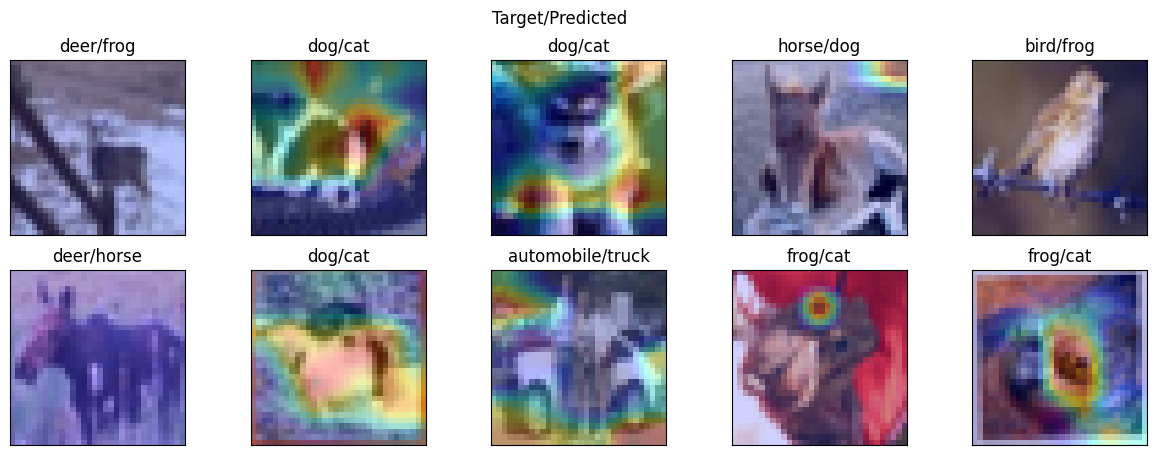

In [28]:
from visualise import plot_incorrect_pred_GradCAM

labels_mapping = {idx:cls for cls, idx in class_map.items()}

target_layers = [load_model.layer3[0]]
plot_incorrect_pred_GradCAM(load_model, target_layers=target_layers, dataset_std=(0.2023, 0.1994, 0.2010), dataset_mean=(0.4914, 0.4822, 0.4465),
                            incorrect_predictions=incorrect, labels_mapping=labels_mapping, use_cuda=use_cuda)

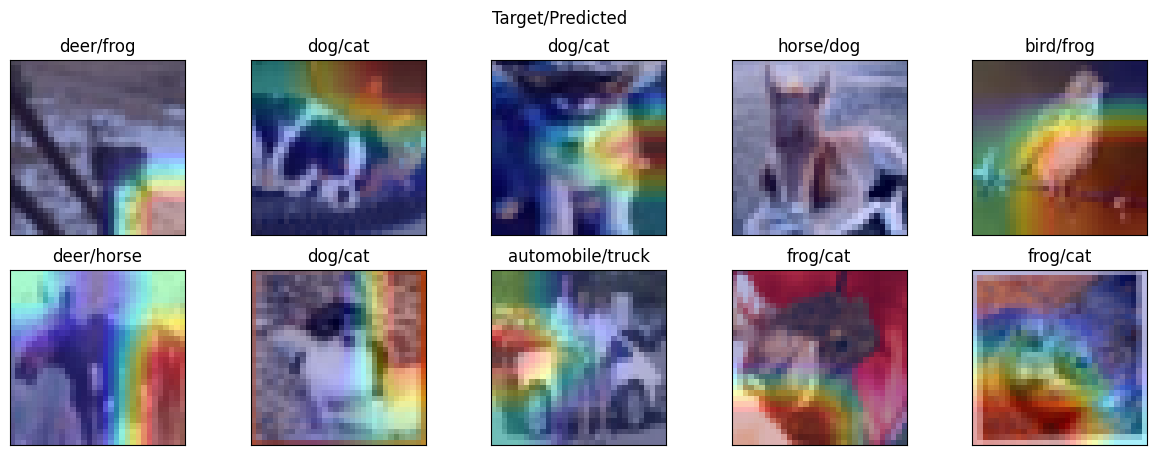

In [29]:
target_layers = [load_model.r2[3]]
plot_incorrect_pred_GradCAM(load_model, target_layers=target_layers, dataset_std=(0.2023, 0.1994, 0.2010), dataset_mean=(0.4914, 0.4822, 0.4465),
                            incorrect_predictions=incorrect, labels_mapping=labels_mapping, use_cuda=use_cuda)